## Build and Train Model
- split data
- rescale
- image augmentation
- build model
- plot results

In [20]:
import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl

### Early processing of metadata for easier model training:

In [21]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
30720,00008009_030.png,No Finding,30,8009,19,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008009_030.png
79798,00019599_000.png,Infiltration,0,19599,59,F,PA,2992,2991,0.143,0.143,NaN,/data/images_009/images/00019599_000.png
34036,00008911_008.png,No Finding,8,8911,63,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00008911_008.png


In [22]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5537,00001483_018.png,Consolidation|Pleural_Thickening,18,1483,55,F,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
108007,00029217_004.png,No Finding,4,29217,61,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
98029,00025854_001.png,No Finding,1,25854,40,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [23]:
# add penumonia_class column to mark negative and positive pneumonia
all_xray_df['pneumonia_class'] = all_xray_df.apply(lambda x: "P" if x.Pneumonia == 1.0 else "N", axis=1)
all_xray_df.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,P
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,N


## Split training and testing data:

In [24]:
def create_splits(df):
    
    train_df, valid_df = skl.train_test_split(df, test_size = 0.2, stratify = df['pneumonia_class'])
    
    p_inds = train_df[train_df['pneumonia_class']=='P'].index.tolist()
    np_inds = train_df[train_df['pneumonia_class']=='N'].index.tolist()
    
    np_sample = sample(np_inds,len(p_inds))
    # final training data with equal numbers of pn and non-pn cases
    train_data = train_df.loc[p_inds + np_sample]
    
    vp_inds = valid_df[valid_df['pneumonia_class']=='P'].index.tolist()
    vnp_inds = valid_df[valid_df['pneumonia_class']=='N'].index.tolist()
    
    vnp_sample = sample(vnp_inds, 4*len(vp_inds))
    # final validation data with 20% pn cases and 80% non-pn cases
    val_data = valid_df.loc[vp_inds + vnp_sample]
    
    x_train = train_df['path']
    y_train = train_df['pneumonia_class']
    
    x_test = valid_df['path']
    y_test = valid_df['pneumonia_class']
    
    return train_data, val_data, x_train, y_train, x_test, y_test

In [25]:
train_data, val_data, x_train, y_train, x_test, y_test = create_splits(all_xray_df)

### Model-building & training

In [26]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input


IMG_SIZE = (224, 224)

# Image augmentation
def my_image_augmentation(df_type):   
    
    if df_type == 'train':
        my_idg = ImageDataGenerator(rescale=None,
                                preprocessing_function=preprocess_input,
                                horizontal_flip = True, 
                                vertical_flip = False, 
                                height_shift_range= 0.1, 
                                width_shift_range=0.1, 
                                rotation_range= 20, 
                                shear_range = 0.1,
                                zoom_range=0.1)
    
    if df_type == 'valid':
        my_idg = ImageDataGenerator(rescale= None,
                                   preprocessing_function=preprocess_input)
                                                          
    
    
    return my_idg


def make_train_gen(train_data):
    my_train_idg = my_image_augmentation('train')
    
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe= train_data, 
                                                 directory= None, 
                                                 x_col = 'path' ,
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = IMG_SIZE, 
                                                 batch_size = 32)
                                         

    return train_gen


def make_val_gen(val_data):
    
    my_val_idg = my_image_augmentation('valid')
    
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = 128) 
    
    return val_gen

In [28]:
train_gen = make_train_gen(train_data)
val_gen = make_val_gen(val_data)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [29]:
valX, valY = val_gen.next()
valX.shape

(128, 224, 224, 3)

In [30]:
t_x, t_y = next(train_gen)
,
print('Train', t_x.min(), t_x.max(), t_x.mean(), t_x.std())

Train -123.68 151.061 17.93604 61.74159


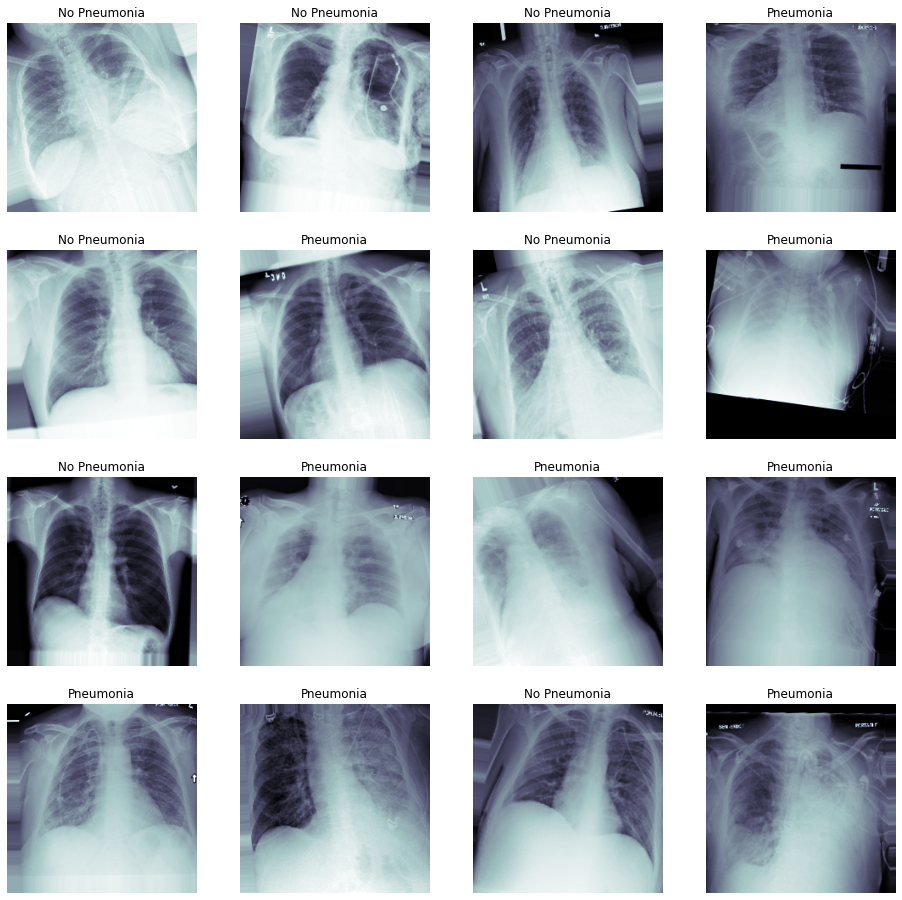

In [31]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build Model: 
Here I use pre-trained network vgg16 from Keras and add my own fine-tuning

In [32]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [33]:
load_pretrained_model()

In [34]:
def build_my_model():
    
    vgg_model = load_pretrained_model()
    my_model = Sequential()
    
    my_model.add(vgg_model)
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    
    my_model.add(Dropout(0.3))
    my_model.add(Dense(256, activation='relu'))
    
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model


In [35]:
optimizer = Adam(lr=3e-5)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
my_model = build_my_model()
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [36]:
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

In [37]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor="val_loss", 
                             verbose=2, 
                             save_best_only=True, 
                             mode='min', 
                             save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                      mode='min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training

In [38]:
# start training

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 50,
                          callbacks = callbacks_list)

Epoch 1/50
72/72 [==============================] - 62s 866ms/step - loss: 2.7034 - binary_accuracy: 0.5271 - val_loss: 0.5505 - val_binary_accuracy: 0.8125

Epoch 00001: val_loss improved from inf to 0.55054, saving model to xray_class_my_model.best.hdf5
Epoch 2/50
72/72 [==============================] - 57s 797ms/step - loss: 1.8436 - binary_accuracy: 0.5214 - val_loss: 0.5556 - val_binary_accuracy: 0.7578

Epoch 00002: val_loss did not improve from 0.55054
Epoch 3/50
72/72 [==============================] - 58s 809ms/step - loss: 1.5988 - binary_accuracy: 0.5131 - val_loss: 0.5401 - val_binary_accuracy: 0.7891

Epoch 00003: val_loss improved from 0.55054 to 0.54012, saving model to xray_class_my_model.best.hdf5
Epoch 4/50
72/72 [==============================] - 58s 799ms/step - loss: 1.2850 - binary_accuracy: 0.5380 - val_loss: 0.5961 - val_binary_accuracy: 0.6797

Epoch 00004: val_loss did not improve from 0.54012
Epoch 5/50
72/72 [==============================] - 58s 809ms/step

### After training - Take a look at the performance by plotting some performance statistics:

In [39]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

128/128 [==============================] - 1s 9ms/step


In [40]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    plt.plot(fpr, tpr, color='red', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')    
    plt.show()
    
    return fpr, tpr, thresholds

def plot_precision_recall_curve(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    plt.plot(recall, precision, color='red', lw=2)
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    
    return precision, recall, thresholds

# calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    

# history of model training
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure(figsize=(20,5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss on Dataset")
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training and Validation Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower left")
    return

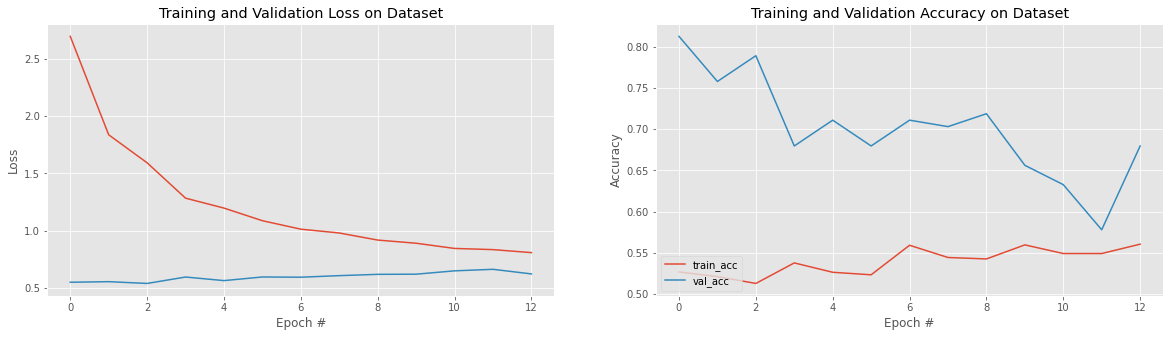

In [41]:
## plot figures
plot_history(history)

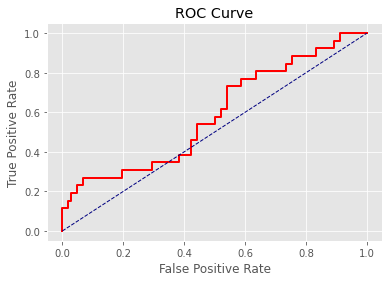

In [42]:
fpr, tpr, thresholds = plot_auc(valY, pred_Y)

In [43]:
df = pd.DataFrame({'False Positive Rate':fpr, 'True Positive Rate':tpr, 'Thresholds':thresholds})
df.tail()

,False Positive Rate,True Positive Rate,Thresholds
37,0.892157,0.923077,0.078371
38,0.892157,0.961538,0.074722
39,0.911765,0.961538,0.072257
40,0.911765,1.000000,0.071797
41,1.000000,1.000000,0.005519


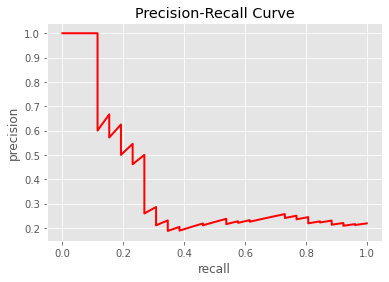

In [45]:
precision, recall, thresholds = plot_precision_recall_curve(valY, pred_Y)

In [46]:
f1 = calc_f1(precision, recall)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [47]:
## Find the threshold that optimize the model's performance,
df = pd.DataFrame({'Precision':precision[:-1], 'Recall':recall[:-1], 'Thresholds':thresholds, 'F1':f1[:-1] })
df.head()

,Precision,Recall,Thresholds,F1
0,0.218487,1.000000,0.071797,0.358621
1,0.211864,0.961538,0.072257,0.347222
2,0.213675,0.961538,0.074174,0.349650
3,0.215517,0.961538,0.074722,0.352113
4,0.208696,0.923077,0.078371,0.340426


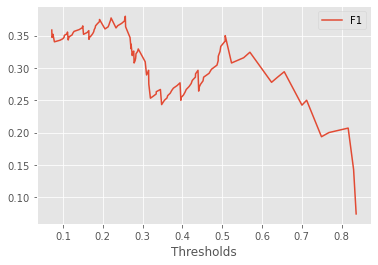

In [48]:
df.plot(x='Thresholds', y='F1', kind='line')

In [49]:
df['F1'].describe()
print('Max F1:', df['F1'].max())
df.iloc[df.F1.idxmax()]

Max F1: 0.38


Precision     0.256757
Recall        0.730769
Thresholds    0.256603
F1            0.380000
Name: 45, dtype: float64

In [50]:
threshold = df.iloc[df.F1.idxmax()]['Thresholds']
print('threshold:', threshold)

threshold: 0.25660330057144165


In [51]:
max_precision = df.iloc[df.F1.idxmax()]['Precision']
print('max precision:', max_precision)

max precision: 0.25675675675675674


In [52]:
max_recall = df.iloc[df.F1.idxmax()]['Recall']
print('max recall:', max_recall)

max recall: 0.7307692307692307


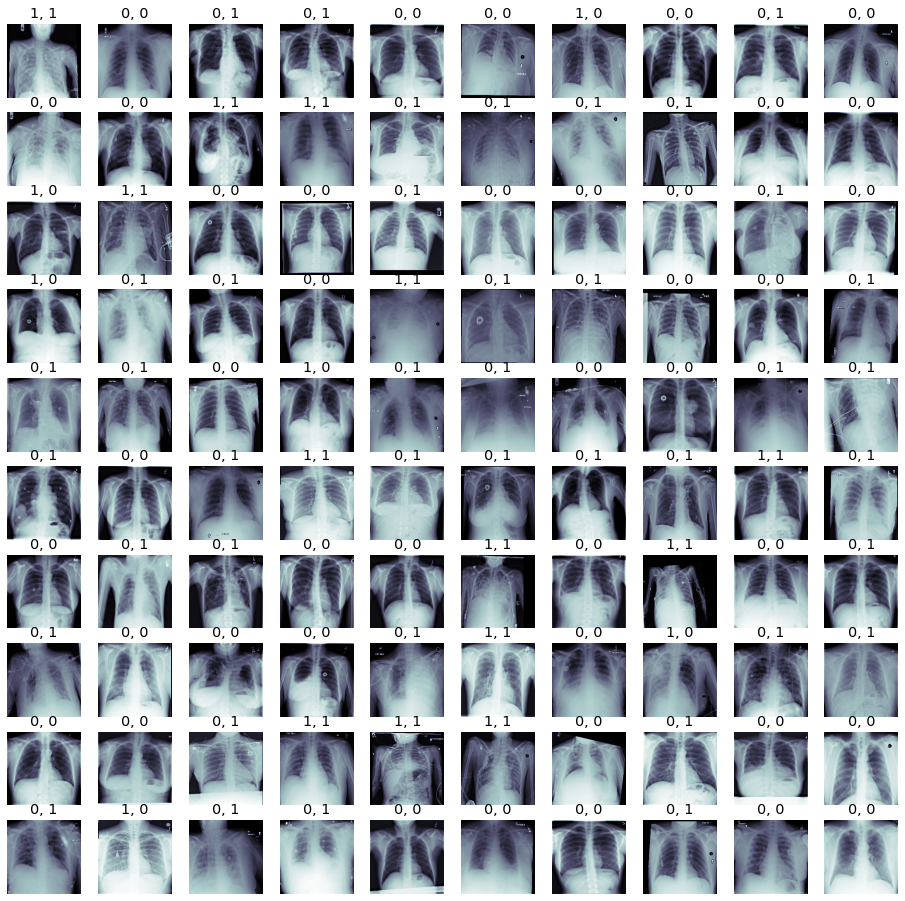

In [53]:
## Take a look at some examples of true vs. predicted with the model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [54]:
## save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)